In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


In [13]:
file_path = '/content/evening clusterxlsx.xlsx'  # replace with your file path
data = pd.read_excel(file_path)

In [14]:
data['Load_Lag_1'] = data['POWER (KW)'].shift(1)     # Previous hour
data['Load_Lag_24'] = data['POWER (KW)'].shift(24)   # Previous day
data['Load_Lag_168'] = data['POWER (KW)'].shift(168) # Previous week

# Create lagged features for seasonal parameters (example: Temperature and Humidity)
data['Temp_Lag_1'] = data['Temp (F)'].shift(1)
data['Temp_Lag_24'] = data['Temp (F)'].shift(24)
data['Humidity_Lag_1'] = data['Humidity (%)'].shift(1)
data['Humidity_Lag_24'] = data['Humidity (%)'].shift(24)


In [15]:
data.dropna(inplace=True)

In [16]:

features = ['Load_Lag_1', 'Load_Lag_24', 'Load_Lag_168', 'Temp_Lag_1', 'Temp_Lag_24', 'Humidity_Lag_1', 'Humidity_Lag_24','"WEEKEND/WEEKDAY"', 'SEASON']
# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features])

# Convert the scaled data back to a DataFrame
scaled_data = pd.DataFrame(scaled_data, columns=features, index=data.index)

In [17]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data.iloc[i + seq_length, 0]  # Load is the target variable
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 24  # Using 24 hours of data to predict the next hour's load
X, y = create_sequences(scaled_data, seq_length)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(seq_length, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=15, epochs=30, validation_split=0.2)

Epoch 1/30
55/55 [==============================] - 12s 86ms/step - loss: 0.0363 - val_loss: 0.0136
Epoch 2/30
55/55 [==============================] - 5s 91ms/step - loss: 0.0196 - val_loss: 0.0124
Epoch 3/30
55/55 [==============================] - 3s 61ms/step - loss: 0.0184 - val_loss: 0.0109
Epoch 4/30
55/55 [==============================] - 3s 60ms/step - loss: 0.0166 - val_loss: 0.0111
Epoch 5/30
55/55 [==============================] - 4s 76ms/step - loss: 0.0162 - val_loss: 0.0156
Epoch 6/30
55/55 [==============================] - 4s 74ms/step - loss: 0.0151 - val_loss: 0.0129
Epoch 7/30
55/55 [==============================] - 3s 59ms/step - loss: 0.0139 - val_loss: 0.0120
Epoch 8/30
55/55 [==============================] - 3s 59ms/step - loss: 0.0137 - val_loss: 0.0102
Epoch 9/30
55/55 [==============================] - 5s 88ms/step - loss: 0.0152 - val_loss: 0.0101
Epoch 10/30
55/55 [==============================] - 3s 58ms/step - loss: 0.0137 - val_loss: 0.0117
Epoch 11

In [20]:
predictions = model.predict(X_test)

8/8 [==============================] - 2s 53ms/step


In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse=mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mpe = (np.mean(np.abs((y_test - predictions) / predictions) )* 100)

print('MSE:', mse)
print('MAE:', mae)
print('R²:', r2)
print('MPE:', mpe)

MSE: 0.0058192737060351225
MAE: 0.051040931605508585
R²: 0.890104737821
MPE: 212.04937172755587


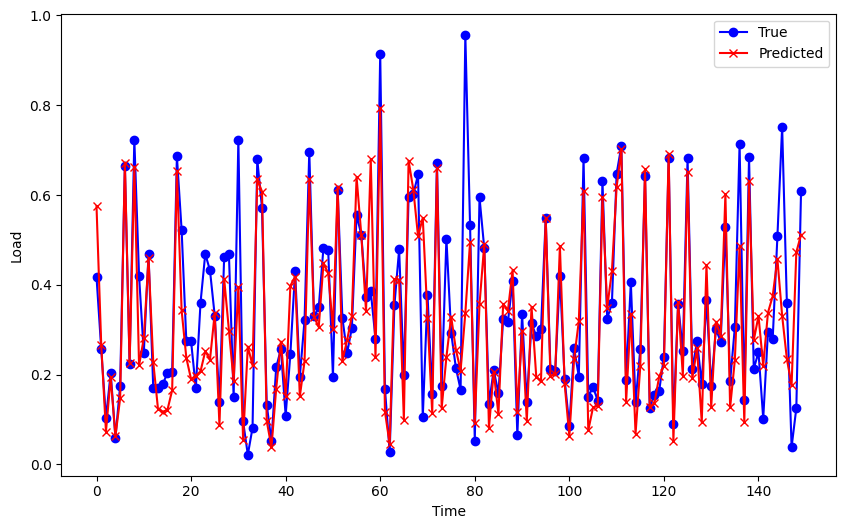

In [21]:
import matplotlib.pyplot as plt

# Define the number of points to display
num_points = 150

# Ensure we only take the first 150 points
y_test_subset = y_test[:num_points]
predictions_subset = predictions[:num_points]

plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_subset)), y_test_subset, color='blue', marker='o', linestyle='-', label='True')
plt.plot(range(len(predictions_subset)), predictions_subset, color='red', marker='x', linestyle='-', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()